# Trust Region Policy Optimization

## Environment I have tested for 

1) Acrobot - 'Acrobot-v1'
2) Lunar Lander - 'LunerLander-v3'
3) HalfCheetah - 'HalfCheetah-v5'
4) Ant - 'Ant-v5'
5) InvertedDoublePendulum


In [1]:
import gymnasium as gym
import torch 
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import time
import matplotlib.pyplot as plt
from IPython import display
import numpy as np


In [2]:
class HyperParams:
    gamma = 0.99
    lamda = 0.98
    hidden = 64
    critic_lr = 0.0003
    actor_lr = 0.0003
    batch_size = 64
    l2_rate = 0.001
    max_kl = 0.01
    clip_param = 0.2

hp = HyperParams()

class Actor(nn.Module):
    def __init__(self, num_inputs, num_outputs, isDiscrete=False):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hp.hidden)
        self.fc2 = nn.Linear(hp.hidden, hp.hidden)
        self.fc3 = nn.Linear(hp.hidden, num_outputs)
        self.fc3.weight.data.mul_(0.1)
        self.fc3.bias.data.mul_(0.0)
        self.isDiscrete = isDiscrete

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        mu = self.fc3(x)
        if self.isDiscrete:
            return mu, None, None
        else:
            logstd = torch.zeros_like(mu)
            std = torch.exp(logstd)
            return mu, std, logstd


class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hp.hidden)
        self.fc2 = nn.Linear(hp.hidden, hp.hidden)
        self.fc3 = nn.Linear(hp.hidden, 1)
        self.fc3.weight.data.mul_(0.1)
        self.fc3.bias.data.mul_(0.0)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        v = self.fc3(x)
        return v


In [3]:
class TRPO:
    def __init__(self, env_name):
        self.env = env_name
        self.num_states = None
        self.num_action = None
        self.isDiscrete = isinstance(gym.make(env_name).action_space, gym.spaces.Discrete)

    def flat_grad(self,grads):
        grad_flatten = []
        for grad in grads:
            grad_flatten.append(grad.view(-1))
        grad_flatten = torch.cat(grad_flatten)
        return grad_flatten


    def flat_hessian(self,hessians):
        hessians_flatten = []
        for hessian in hessians:
            hessians_flatten.append(hessian.contiguous().view(-1))
        hessians_flatten = torch.cat(hessians_flatten).data
        return hessians_flatten


    def flat_params(self,model):
        params = []
        for param in model.parameters():
            params.append(param.data.view(-1))
        params_flatten = torch.cat(params)
        return params_flatten


    def update_model(self,model, new_params):
        index = 0
        for params in model.parameters():
            params_length = len(params.view(-1))
            new_param = new_params[index: index + params_length]
            new_param = new_param.view(params.size())
            params.data.copy_(new_param)
            index += params_length

    def kl_divergence(self, new_actor, old_actor, states):
        if self.isDiscrete:
            logits_new = new_actor(torch.Tensor(states))[0]
            logits_old = old_actor(torch.Tensor(states))[0].detach()

            dist_new = torch.distributions.Categorical(logits=logits_new)
            dist_old = torch.distributions.Categorical(logits=logits_old)

            kl = torch.distributions.kl_divergence(dist_old, dist_new)
            return kl.unsqueeze(1)
        else:
            mu, std, logstd = new_actor(torch.Tensor(states))
            mu_old, std_old, logstd_old = old_actor(torch.Tensor(states))
            mu_old = mu_old.detach()
            std_old = std_old.detach()
            logstd_old = logstd_old.detach()

            kl = logstd_old - logstd + (std_old.pow(2) + (mu_old - mu).pow(2)) / \
                (2.0 * std.pow(2)) - 0.5
            return kl.sum(1, keepdim=True)


    def get_gae(self, rewards, masks, values):
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)
        returns = torch.zeros_like(rewards)
        advants = torch.zeros_like(rewards)

        running_returns = 0
        previous_value = 0
        running_advants = 0

        for t in reversed(range(0, len(rewards))):
            running_returns = rewards[t] + hp.gamma * running_returns * masks[t]
            running_tderror = rewards[t] + hp.gamma * previous_value * masks[t] - \
                        values.data[t]
            running_advants = running_tderror + hp.gamma * hp.lamda * \
                            running_advants * masks[t]

            returns[t] = running_returns
            previous_value = values.data[t]
            advants[t] = running_advants

        advants = (advants - advants.mean()) / advants.std()
        return returns, advants


    def surrogate_loss(self, actor, advants, states, old_policy, actions):
        if self.isDiscrete:
            logits = actor(torch.Tensor(states))[0]
            dist = torch.distributions.Categorical(logits=logits)
            new_policy = dist.log_prob(torch.Tensor(actions).squeeze().long()).unsqueeze(1)
        else:
            mu, std, logstd = actor(torch.Tensor(states))
            new_policy = self.log_density(torch.Tensor(actions), mu, std, logstd)

        advants = advants.unsqueeze(1)

        surrogate = advants * torch.exp(new_policy - old_policy)
        surrogate = surrogate.mean()
        return surrogate

    def log_density(self,x, mu, std, logstd):
        var = std.pow(2)
        log_density = - (x - mu).pow(2) / (2 * var) - 0.5 * np.log(2 * np.pi) - logstd
        return log_density.sum(1, keepdim=True)

    def get_returns(self,rewards, masks):
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)
        returns = torch.zeros_like(rewards)

        running_returns = 0

        for t in reversed(range(0, len(rewards))):
            running_returns = rewards[t] + hp.gamma * running_returns * masks[t]
            returns[t] = running_returns

        returns = (returns - returns.mean()) / returns.std()
        return returns


    def get_loss(self, actor, returns, states, actions):
        states = torch.Tensor(states)
        actions = torch.Tensor(actions)
        returns = returns.unsqueeze(1)
        
        if self.isDiscrete:
            logits = actor(states)[0]
            dist = torch.distributions.Categorical(logits=logits)
            log_policy = dist.log_prob(actions.squeeze().long()).unsqueeze(1)
        else:
            mu, std, logstd = actor(states)
            log_policy = self.log_density(actions, mu, std, logstd)
        
        objective = (returns * log_policy).mean()
        return -objective



    def train_critic(self,critic, states, returns, advants, critic_optim):
        criterion = torch.nn.MSELoss()
        n = len(states)
        arr = np.arange(n)

        for epoch in range(5):
            np.random.shuffle(arr)

            for i in range(n // hp.batch_size):
                batch_index = arr[hp.batch_size * i: hp.batch_size * (i + 1)]
                batch_index = torch.LongTensor(batch_index)
                inputs = torch.Tensor(states)[batch_index]
                target1 = returns.unsqueeze(1)[batch_index]
                target2 = advants.unsqueeze(1)[batch_index]

                values = critic(inputs)
                loss = criterion(values, target1 + target2)
                critic_optim.zero_grad()
                loss.backward()
                critic_optim.step()

    def fisher_vector_product(self,actor, states, p):
        p.detach()
        kl = self.kl_divergence(new_actor=actor, old_actor=actor, states=states)
        kl = kl.mean()
        kl_grad = torch.autograd.grad(kl, actor.parameters(), create_graph=True)
        kl_grad = self.flat_grad(kl_grad)  # check kl_grad == 0

        kl_grad_p = (kl_grad * p).sum()
        kl_hessian_p = torch.autograd.grad(kl_grad_p, actor.parameters())
        kl_hessian_p = self.flat_hessian(kl_hessian_p)

        return kl_hessian_p + 0.1 * p
    
    def conjugate_gradient(self,actor, states, b, nsteps, residual_tol=1e-10):
        x = torch.zeros(b.size())
        r = b.clone()
        p = b.clone()
        rdotr = torch.dot(r, r)
        for i in range(nsteps):
            _Avp = self.fisher_vector_product(actor, states, p)
            alpha = rdotr / torch.dot(p, _Avp)
            x += alpha * p
            r -= alpha * _Avp
            new_rdotr = torch.dot(r, r)
            betta = new_rdotr / rdotr
            p = r + betta * p
            rdotr = new_rdotr
            if rdotr < residual_tol:
                break
        return x


    def train_actor(self,actor, returns, states, actions, actor_optim):
        loss = self.get_loss(actor, returns, states, actions)
        actor_optim.zero_grad()
        loss.backward()
        actor_optim.step()


    def train_model(self, actor, critic, memory, actor_optim, critic_optim):
        states = np.vstack([m[0] for m in memory])
        actions = np.vstack([m[1] for m in memory])
        rewards = [m[2] for m in memory]
        masks = [m[3] for m in memory]
        values = critic(torch.Tensor(states))
 

        # ----------------------------
        # step 1: get returns and GAEs
        returns, advants = self.get_gae(rewards, masks, values)

        # ----------------------------
        # step 2: train critic several steps with respect to returns
        self.train_critic(critic, states, returns, advants, critic_optim)

        # ----------------------------
        # step 3: get gradient of loss and hessian of kl
        if self.isDiscrete:
            logits = actor(torch.Tensor(states))[0]
            dist = torch.distributions.Categorical(logits=logits)
            old_policy = dist.log_prob(torch.Tensor(actions).squeeze().long()).unsqueeze(1)
        else:
            mu, std, logstd = actor(torch.Tensor(states))
            old_policy = self.log_density(torch.Tensor(actions), mu, std, logstd)


        loss = self.surrogate_loss(actor, advants, states, old_policy.detach(), actions)
        loss_grad = torch.autograd.grad(loss, actor.parameters())
        loss_grad = self.flat_grad(loss_grad)
        step_dir = self.conjugate_gradient(actor, states, loss_grad.data, nsteps=10)

        # ----------------------------
        # step 4: get step direction and step size and full step
        params = self.flat_params(actor)
        shs = 0.5 * (step_dir * self.fisher_vector_product(actor, states, step_dir)
                    ).sum(0, keepdim=True)
        step_size = 1 / torch.sqrt(shs / hp.max_kl)[0]
        full_step = step_size * step_dir

        # ----------------------------
        # step 5: do backtracking line search for n times
        old_actor = Actor(actor.num_inputs, actor.num_outputs)
        self.update_model(old_actor, params)
        expected_improve = (loss_grad * full_step).sum(0, keepdim=True)

        flag = False
        fraction = 1.0
        for i in range(10):
            new_params = params + fraction * full_step
            self.update_model(actor, new_params)
            new_loss = self.surrogate_loss(actor, advants, states, old_policy.detach(),
                                    actions)
            loss_improve = new_loss - loss
            expected_improve *= fraction
            kl = self.kl_divergence(new_actor=actor, old_actor=old_actor, states=states)
            kl = kl.mean()

            print('kl: {:.4f}  loss improve: {:.4f}  expected improve: {:.4f}  '
                'number of line search: {}'
                .format(kl.data.numpy(), loss_improve, expected_improve[0], i))

            # see https: // en.wikipedia.org / wiki / Backtracking_line_search
            if kl < hp.max_kl and (loss_improve / expected_improve) > 0.5:
                flag = True
                break

            fraction *= 0.5

        if not flag:
            params = self.flat_params(old_actor)
            self.update_model(actor, params)
            print('policy update does not impove the surrogate')

    def make_env(self):
        env = gym.make(self.env)
        return env
    

    def get_action(self, actor, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        if self.isDiscrete:
            logits = actor(state_tensor)[0]
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample().item() 
        else:
            mu, std, _ = actor(state_tensor)
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample().squeeze(0).detach().numpy()
            action = np.clip(action, -1, 1) 
        return action

    
    def main(self):
        env = self.make_env()

        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n if self.isDiscrete else env.action_space.shape[0]

        print("State space: ", self.num_states)
        print("Action space: ", self.num_actions)

        actor = Actor(self.num_states, self.num_actions, self.isDiscrete)
        critic = Critic(self.num_states)

        actor_optim = optim.Adam(actor.parameters(), lr=hp.actor_lr)
        critic_optim = optim.Adam(critic.parameters(), lr=hp.critic_lr, weight_decay=hp.l2_rate)

        writer = SummaryWriter(log_dir=f"runs/{self.env}_TRPO")

        episodes = 0
        scores_over_time = []
        for iter in range(50):
            actor.eval(), critic.eval()
            memory = deque()

            steps = 0
            scores = []
            while steps < 10000:
                episodes += 1
                state = env.reset(seed=42)[0] 
                score = 0
                for _ in range(10000):

                    steps += 1 
                    
                    action = self.get_action(actor, state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    if done:
                        mask = 0
                    else:
                        mask = 1

                    memory.append([state, action, reward, mask])

                    score += reward
                    state = next_state

                    if done:
                        break
                scores.append(score)
            score_avg = np.mean(scores)
            scores_over_time.append(score_avg)
            print('{} episode score is {:.2f}'.format(episodes, score_avg))
            writer.add_scalar('log/score', float(score_avg), iter)

            actor.train(), critic.train()
            torch.save(actor.state_dict(), f'actor_{self.env}_TRPO.pth')
            torch.save(critic.state_dict(), f'critic_{self.env}_TRPO.pth')
            self.train_model(actor, critic, memory, actor_optim, critic_optim)

        np.save(f"scores_{self.env}_TRPO.npy", np.array(scores_over_time))

In [4]:
trpo = TRPO('HalfCheetah-v5')
trpo.main()

State space:  17
Action space:  6
10 episode score is -305.57
kl: 0.0054  loss improve: 0.0112  expected improve: 0.0111  number of line search: 0
20 episode score is -326.95
kl: 0.0046  loss improve: 0.0104  expected improve: 0.0105  number of line search: 0
30 episode score is -374.61
kl: 0.0049  loss improve: 0.0112  expected improve: 0.0113  number of line search: 0
40 episode score is -283.91
kl: 0.0048  loss improve: 0.0118  expected improve: 0.0120  number of line search: 0
50 episode score is -329.51
kl: 0.0049  loss improve: 0.0125  expected improve: 0.0124  number of line search: 0
60 episode score is -347.24
kl: 0.0056  loss improve: 0.0150  expected improve: 0.0148  number of line search: 0
70 episode score is -306.48
kl: 0.0044  loss improve: 0.0129  expected improve: 0.0133  number of line search: 0
80 episode score is -317.97
kl: 0.0047  loss improve: 0.0141  expected improve: 0.0146  number of line search: 0
90 episode score is -355.24
kl: 0.0043  loss improve: 0.0130  

6
HalfCheetah-v5


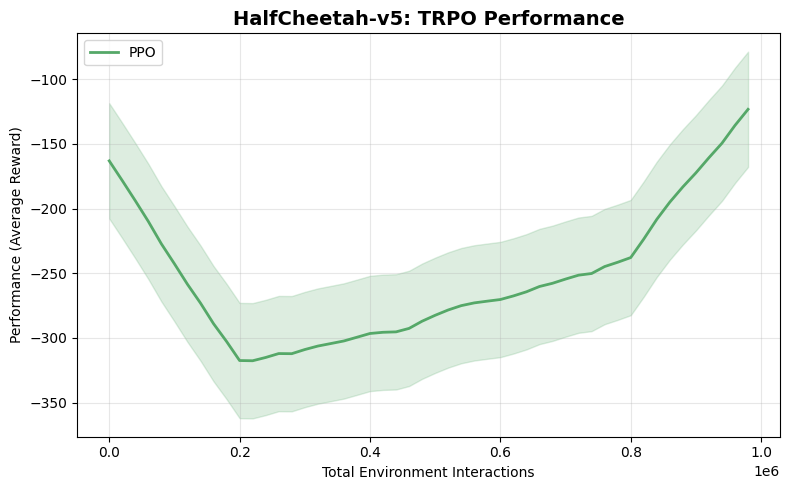

In [5]:
print(trpo.num_actions)
print(trpo.env)

actor = Actor(trpo.num_states, trpo.num_actions, trpo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{trpo.env}_TRPO.pth"))

env = trpo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{trpo.env}_TRPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{trpo.env}: TRPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
trpo = TRPO('Acrobot-v1')
trpo.main()

State space:  6
Action space:  3
20 episode score is -500.00
kl: 0.0066  loss improve: 0.0038  expected improve: 0.0037  number of line search: 0
40 episode score is -500.00
kl: 0.0046  loss improve: 0.0038  expected improve: 0.0038  number of line search: 0
60 episode score is -500.00
kl: 0.0047  loss improve: 0.0041  expected improve: 0.0042  number of line search: 0
80 episode score is -500.00
kl: 0.0075  loss improve: 0.0055  expected improve: 0.0055  number of line search: 0
101 episode score is -488.62
kl: 0.0057  loss improve: 0.0038  expected improve: 0.0038  number of line search: 0
123 episode score is -465.91
kl: 0.0063  loss improve: 0.0076  expected improve: 0.0070  number of line search: 0
150 episode score is -377.59
kl: 0.0081  loss improve: 0.0090  expected improve: 0.0092  number of line search: 0
189 episode score is -258.41
kl: 0.0084  loss improve: 0.0122  expected improve: 0.0125  number of line search: 0
237 episode score is -210.88
kl: 0.0082  loss improve: 0.01

3
Acrobot-v1


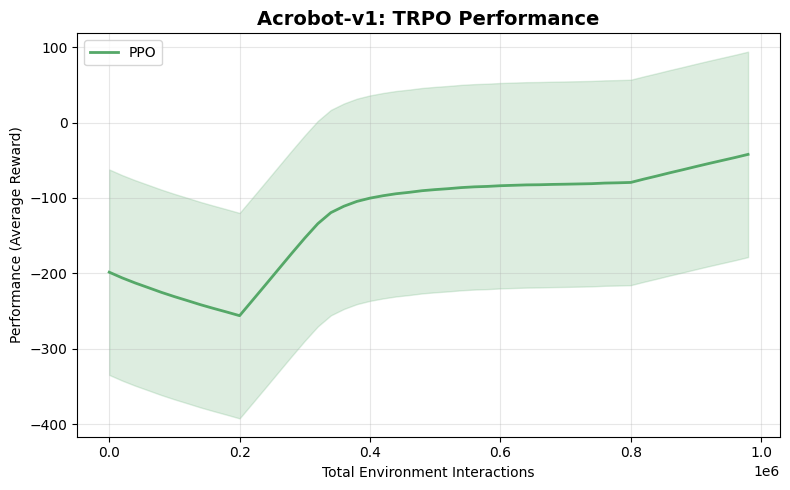

In [7]:


print(trpo.num_actions)
print(trpo.env)

actor = Actor(trpo.num_states, trpo.num_actions, trpo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{trpo.env}_TRPO.pth"))

env = trpo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{trpo.env}_TRPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{trpo.env}: TRPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
trpo = TRPO('LunarLander-v3')
trpo.main()

State space:  8
Action space:  4


/Users/trijalsrivastava/Code/CS778/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


87 episode score is -201.04
kl: 0.0072  loss improve: 0.0100  expected improve: 0.0101  number of line search: 0
175 episode score is -181.07
kl: 0.0066  loss improve: 0.0079  expected improve: 0.0075  number of line search: 0
260 episode score is -166.97
kl: 0.0077  loss improve: 0.0136  expected improve: 0.0122  number of line search: 0
345 episode score is -126.00
kl: 0.0063  loss improve: 0.0090  expected improve: 0.0081  number of line search: 0
428 episode score is -117.16
kl: 0.0061  loss improve: 0.0127  expected improve: 0.0121  number of line search: 0
506 episode score is -95.26
kl: 0.0065  loss improve: 0.0095  expected improve: 0.0091  number of line search: 0
582 episode score is -82.83
kl: 0.0072  loss improve: 0.0116  expected improve: 0.0113  number of line search: 0
655 episode score is -59.51
kl: 0.0074  loss improve: 0.0102  expected improve: 0.0097  number of line search: 0
723 episode score is -45.92
kl: 0.0078  loss improve: 0.0125  expected improve: 0.0123  numb

4
LunarLander-v3


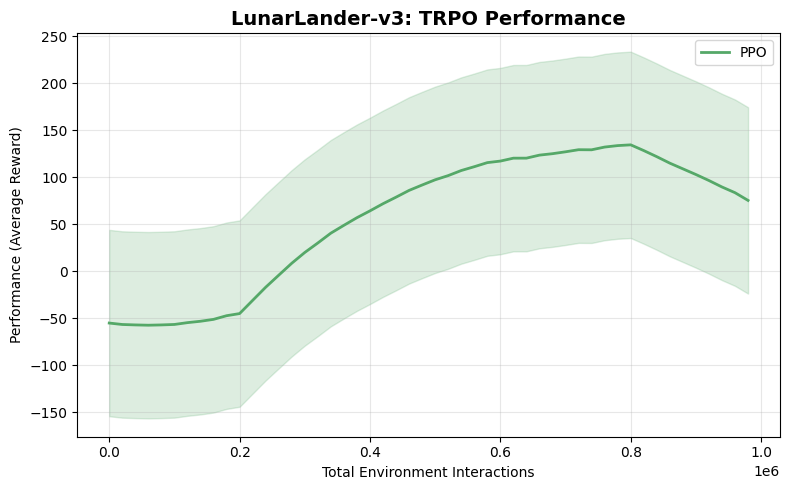

In [9]:


print(trpo.num_actions)
print(trpo.env)

actor = Actor(trpo.num_states, trpo.num_actions, trpo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{trpo.env}_TRPO.pth"))

env = trpo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{trpo.env}_TRPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{trpo.env}: TRPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
trpo = TRPO('Ant-v5')
trpo.main()

State space:  105
Action space:  8
94 episode score is -123.55
kl: 0.0057  loss improve: 0.0084  expected improve: 0.0086  number of line search: 0
222 episode score is -92.57
kl: 0.0058  loss improve: 0.0105  expected improve: 0.0103  number of line search: 0
300 episode score is -141.00
kl: 0.0052  loss improve: 0.0100  expected improve: 0.0104  number of line search: 0
379 episode score is -142.14
kl: 0.0060  loss improve: 0.0111  expected improve: 0.0112  number of line search: 0
488 episode score is -104.31
kl: 0.0050  loss improve: 0.0113  expected improve: 0.0115  number of line search: 0
553 episode score is -186.83
kl: 0.0051  loss improve: 0.0111  expected improve: 0.0115  number of line search: 0
678 episode score is -97.93
kl: 0.0057  loss improve: 0.0118  expected improve: 0.0122  number of line search: 0
779 episode score is -113.97
kl: 0.0055  loss improve: 0.0123  expected improve: 0.0127  number of line search: 0
895 episode score is -93.77
kl: 0.0048  loss improve: 0.

8
Ant-v5


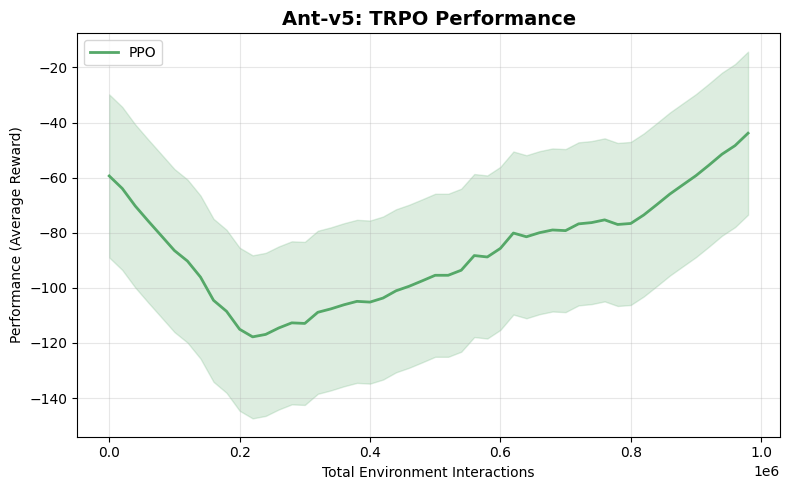

In [11]:


print(trpo.num_actions)
print(trpo.env)

actor = Actor(trpo.num_states, trpo.num_actions, trpo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{trpo.env}_TRPO.pth"))

env = trpo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{trpo.env}_TRPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{trpo.env}: TRPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
trpo = TRPO('Reacher-v5')
trpo.main()

State space:  10
Action space:  2
200 episode score is -60.96
kl: 0.0068  loss improve: 0.0041  expected improve: 0.0041  number of line search: 0
400 episode score is -61.19
kl: 0.0066  loss improve: 0.0054  expected improve: 0.0051  number of line search: 0
600 episode score is -60.52
kl: 0.0070  loss improve: 0.0062  expected improve: 0.0053  number of line search: 0
800 episode score is -61.28
kl: 0.0062  loss improve: 0.0066  expected improve: 0.0064  number of line search: 0
1000 episode score is -60.88
kl: 0.0057  loss improve: 0.0050  expected improve: 0.0047  number of line search: 0
1200 episode score is -60.71
kl: 0.0078  loss improve: 0.0073  expected improve: 0.0073  number of line search: 0
1400 episode score is -61.29
kl: 0.0057  loss improve: 0.0060  expected improve: 0.0065  number of line search: 0
1600 episode score is -61.56
kl: 0.0062  loss improve: 0.0052  expected improve: 0.0058  number of line search: 0
1800 episode score is -62.01
kl: 0.0052  loss improve: 0.0

2
Reacher-v5


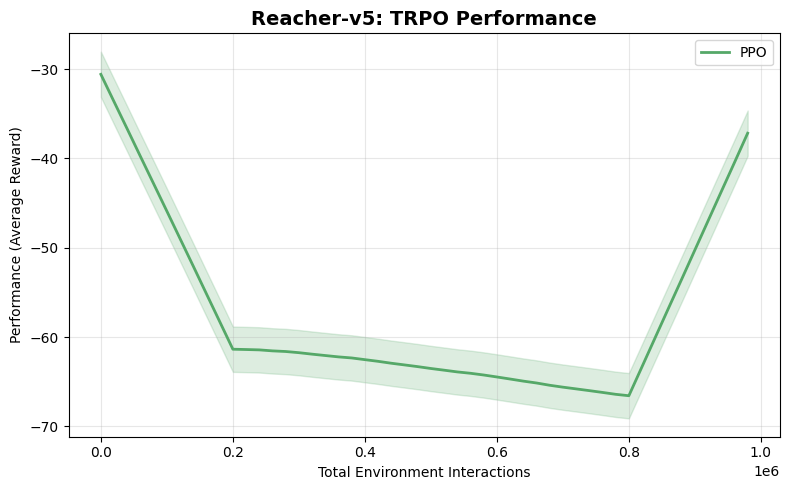

In [13]:
print(trpo.num_actions)
print(trpo.env)

actor = Actor(trpo.num_states, trpo.num_actions, trpo.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{trpo.env}_TRPO.pth"))

env = trpo.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{trpo.env}_TRPO.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PPO")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{trpo.env}: TRPO Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Total episode reward: -68.40051704543144


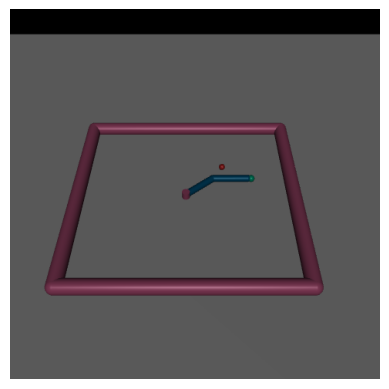

In [14]:
frames = []  # for inline animation
while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    if actor.isDiscrete:
        logits, _, _ = actor(state_tensor)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample().item()
    else:
        mu, std, _ = actor(state_tensor)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample().squeeze(0).detach().numpy()
        action = np.clip(action, env.action_space.low, env.action_space.high)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

    frame = env.render()  
    frames.append(frame)

    state = next_state

for frame in frames:
    plt.imshow(frame)
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.03)


print("Total episode reward:", total_reward)
env.close()

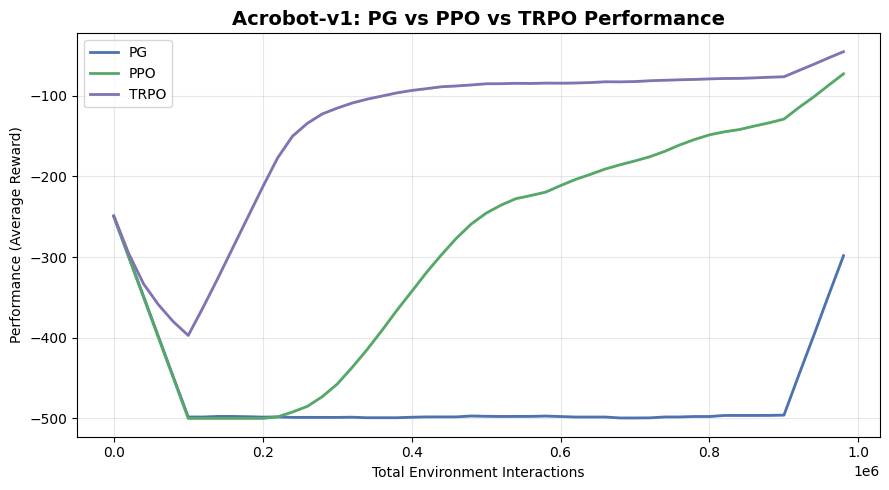

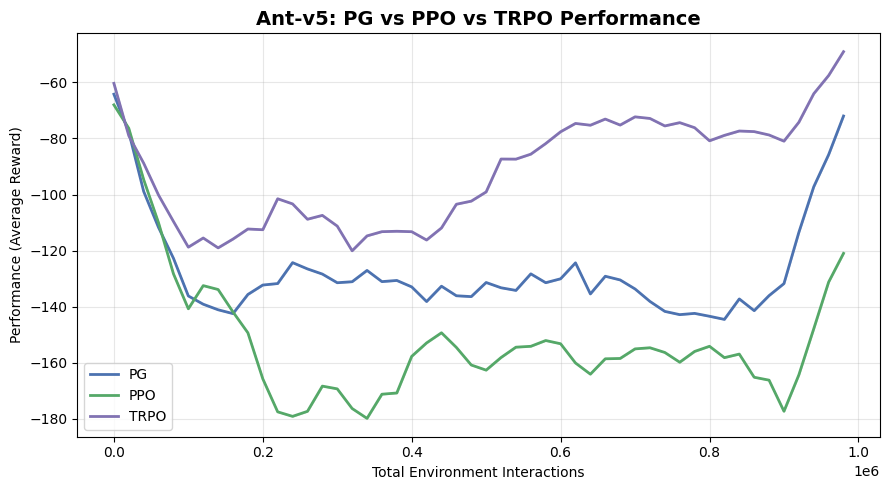

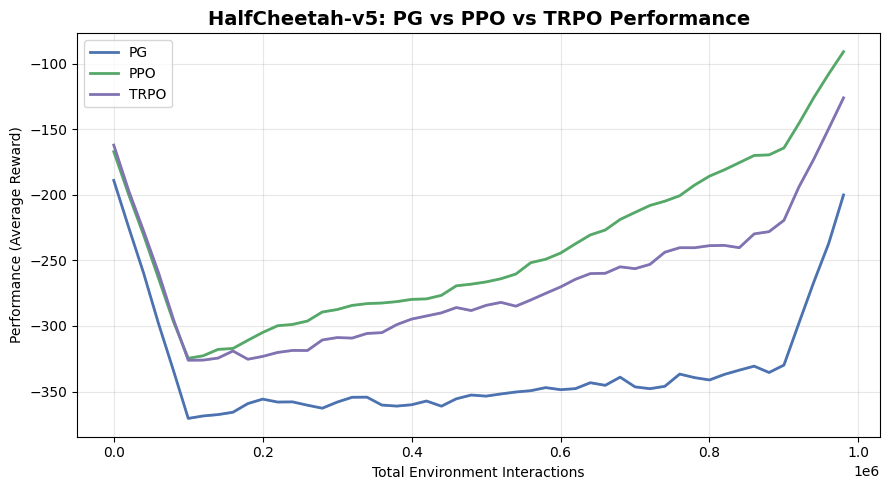

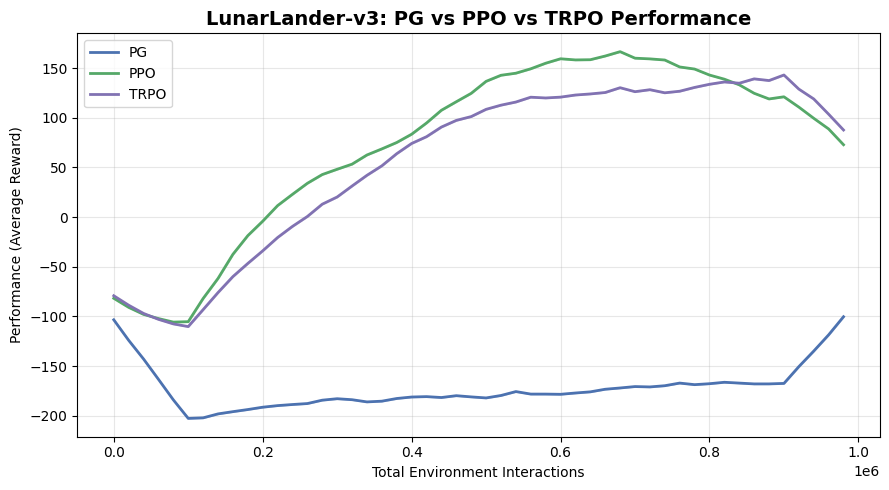

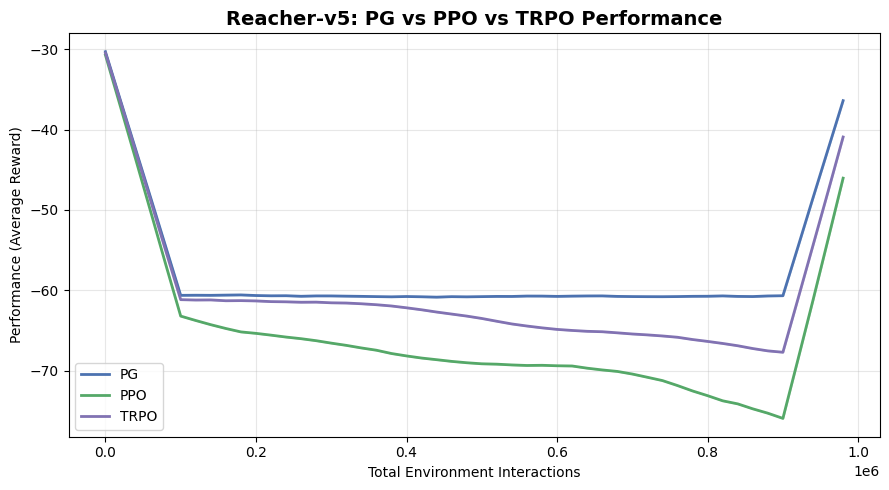

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

plt.style.use('seaborn-v0_8-muted')
 
colors = {
    "PG": "#4C72B0",      
    "PPO": "#55A868",     
    "TRPO": "#8172B2"    
}
 
def smooth(y, box_pts=10):
    if len(y) < box_pts:
        return y
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
 
files = sorted(glob.glob("scores_*.npy")) 
envs = sorted(set(["_".join(f.split("_")[1:-1]) for f in files]))
 
for env in envs:
    plt.figure(figsize=(9, 5)) 

    for algo in ["PG", "PPO", "TRPO"]:
        matching_files = [f for f in files if env in f and algo in f]
        if not matching_files:
            continue

        data = [np.load(f) for f in matching_files if os.path.getsize(f) > 0]
        if not data:
            continue

        rewards = np.array([d for d in data if len(d) > 0])
        if len(rewards.shape) == 1:
            rewards = rewards.reshape(1, -1)

        mean = np.mean(rewards, axis=0)
        std = np.std(rewards, axis=0)

        timesteps = np.arange(len(mean)) * 20000  
        smoothed_mean = smooth(mean, box_pts=10)

        plt.plot(timesteps, smoothed_mean, label=algo, color=colors[algo], linewidth=2)
        plt.fill_between(timesteps, smoothed_mean - std, smoothed_mean + std, color=colors[algo], alpha=0.2)

    plt.title(f"{env}: PG vs PPO vs TRPO Performance", fontsize=14, fontweight='bold')
    plt.xlabel("Total Environment Interactions")
    plt.ylabel("Performance (Average Reward)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{env}_comparison.png", dpi=300)
    plt.show()
 
